# Anisotropic Network Model (ANM) Tutorial

ANM calculations are carried out the same way as GNM calculations except that the ANM uses the Hessian matrix rather than the Kirchhoff matrix. There are also additional analysis options arising from the modes being 3D such as visualization in VMD using the normal mode wizard (NMWiz) and comparison to transitions between experimental structures.

In [1]:
from prody import *
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
confProDy(auto_show=False)
confProDy(auto_secondary=True)

@> ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True


First we parse a structure from the PDB. We will use the open structure of adenylate kinase and also parse the closed structure for comparison later. We exclude the flexible C-terminus.

In [2]:
open_aa = parsePDB('4ake', compressed=False) # if not specifying compressed=False, it will just download the file zipped

@> PDB file is found in working directory (4ake.pdb).
@> 3459 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> Secondary structures were assigned to 279 residues.


In [3]:
open_ca = open_aa.select('calpha and chain A')
open_ca

<Selection: 'calpha and chain A' from 4ake (214 atoms)>

In [4]:
closed_aa = parsePDB('1ake', compressed=False)

@> PDB file is found in working directory (1ake.pdb).
@> 3804 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> Secondary structures were assigned to 306 residues.


In [5]:
closed_ca = closed_aa.select('calpha and chain A')
closed_ca

<Selection: 'calpha and chain A' from 1ake (214 atoms)>

Next, we instantiate an ANM model for the resting state.

In [6]:
anm_open = ANM('open AKE')

We then build the Hessian matrix and calculate normal modes.

In [7]:
anm_open.buildHessian(open_ca)

@> Hessian was built in 0.11s.


In [8]:
anm_open.calcModes() # anm_open.calcModes(n_modes=all) or anm_open.calcModes(n_modes=None)

@> 20 modes were calculated in 0.05s.


We can calculate or show mode shapes, square fluctuations, and covariance and cross-correlation matrices as we did with the GNM.

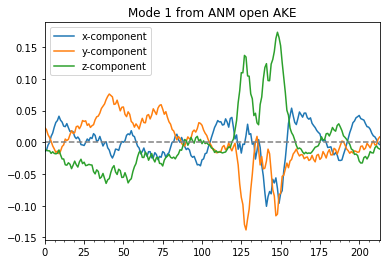

In [9]:
showMode(anm_open[0]);
legend();

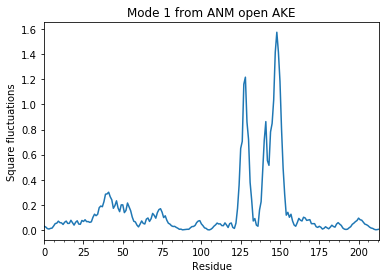

In [10]:
showSqFlucts(anm_open[0]);

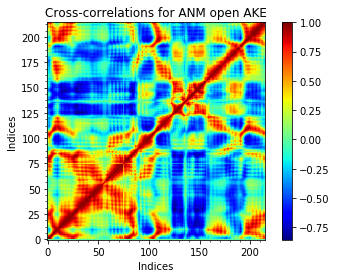

In [11]:
#CC = calcCrossCorr(anm_open)
#showMatrix(CC)
showCrossCorr(anm_open);

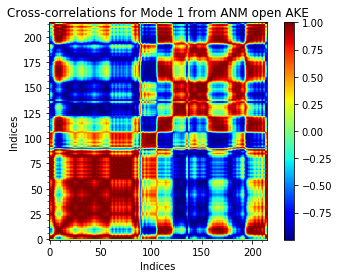

In [12]:
#CC = calcCrossCorr(anm_open[0])
#showMatrix(CC)
showCrossCorr(anm_open[0]);

In order to visualize these modes in NMWiz, we write them to a .nmd file using writeNMD.

In [13]:
writeNMD('anm_open_ake', anm_open, open_ca)

'anm_open_ake'

Before we load them into VMD, we identify the matching residues between the resting and active structures so we can align them and assess how well the modes match the activation transition.

We then align the matched structures and write them as PDBs to aid in our visualization and confirm the alignment.

In [14]:
calcRMSD(closed_ca, open_ca)

75.04657622215835

In [15]:
aligned_closed_ca, T = superpose(closed_ca, open_ca) # superpose is inplace function

In [16]:
calcRMSD(aligned_closed_ca, open_ca)

7.130700152775837

In [17]:
writePDB('1akeA_ca_alg.pdb', aligned_closed_ca)

'1akeA_ca_alg.pdb'

In [18]:
writePDB('4akeA_ca.pdb', open_ca)

'4akeA_ca.pdb'

We can then open up VMD from iPython using an exclamation mark to say it is a command for the operating system not a python command. You can find the NMWiz under Extensions --> Analysis --> Normal Mode Wizard

In [19]:
!vmd

/bin/sh: vmd: command not found


We can also systematically compare the modes from the resting structure to the transition to the active structure as follows. The first step is to use sliceModel to slice the ANM using the selection corresponding to the matching residues.

We can see that the sliced ANM has fewer nodes as expected.

The next step is to calculate the deformation vector corresponding to the transition from resting to active, which we can compare against the ANM modes:

In [20]:
defvec = calcDeformVector(open_ca, aligned_closed_ca)

We then show the overlap or correlation cosine between the ANM modes and the deformation vector as follows. The cumulative overlap is the square root of the sum of squared overlaps.

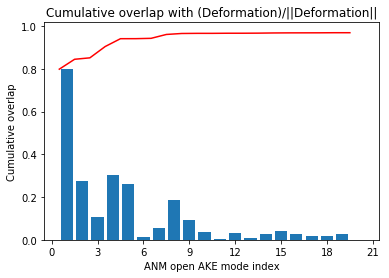

In [21]:
showOverlap(defvec.getNormed(), anm_open)
showCumulOverlap(defvec.getNormed(), anm_open, 'r')

We see that mode 2 overlaps best with this transition as we observed in NMWiz.

We can also write ANM modes and deformation vectors to PDB files for visualisation. We can also include all the atoms using the function extendModel, which assigns the vector of each CA to all the atoms of the corresponding residue.

The first step is to extend the ANM modes from only CA to all atoms.

In [22]:
ca_mode1 = traverseMode(anm_open[0], open_ca, rmsd=5.0)
ca_mode1.setAtoms(open_ca)

@> Parameter: rmsd = 5.00 A
@> Parameter: n_steps = 10
@> Step size is 0.50 A RMSD
@> Mode is scaled by 1.2796916122852697.


In [23]:
calcRMSD(aligned_closed_ca, ca_mode1[-1])

4.3475290961951645

In [24]:
aa_anm, aa_atoms = extendModel(anm_open, open_ca, open_aa)

The next step is to traverse the mode and create intermediate conformations along it. This takes steps in both directions starting from the provided structure.

In [25]:
aa_mode1 = traverseMode(aa_anm[0], aa_atoms)
aa_mode1

@> Parameter: rmsd = 1.50 A
@> Parameter: n_steps = 10
@> Step size is 0.15 A RMSD
@> Mode is scaled by 1.0679493809502514.


<Ensemble: Conformations along Mode 1 from NMA Extended ANM open AKE (21 conformations; 1656 atoms)>

In [26]:
aa_mode1.setAtoms(aa_atoms)

In [27]:
writePDB('4ake_all-atom_mode1.pdb', aa_mode1)

'4ake_all-atom_mode1.pdb'

In [28]:
!vmd 4ake_all-atom_mode1.pdb

/bin/sh: vmd: command not found


In [31]:
writeNMD('4ake_aa_anm.pdb', aa_anm, aa_atoms)

'4ake_aa_anm.pdb'

In [30]:
!vmd

/bin/sh: vmd: command not found
